In [30]:

import pandas as pd
import numpy as np
from scipy.stats import randint
import seaborn as sns # used for plot interactive graph. 
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
#import warnings
#warnings.filterwarnings("ignore", category=FutureWarning)


In [31]:
df = pd.read_csv('dataset/consumer/rows.csv',nrows=50000)
df.shape


(50000, 18)

In [32]:
df.head(2).T 

,0,1
Date received,05/10/2019,05/10/2019
Product,Checking or savings account,Checking or savings account
Sub-product,Checking account,Other banking product or service
Issue,Managing an account,Managing an account
Sub-issue,Problem using a debit or ATM card,Deposits and withdrawals
Consumer complaint narrative,NaN,NaN
Company public response,NaN,NaN
Company,NAVY FEDERAL CREDIT UNION,BOEING EMPLOYEES CREDIT UNION
State,FL,WA
ZIP code,328XX,98204


In [33]:
# Create a new dataframe with two columns
df1 = df[['Product', 'Consumer complaint narrative']].copy()

# Remove missing values (NaN)
df1 = df1[pd.notnull(df1['Consumer complaint narrative'])]

# Renaming second column for a simpler name
df1.columns = ['Product', 'Consumer_complaint'] 

df1.shape


(2646, 2)

In [34]:


# Percentage of complaints with text
total = df1['Consumer_complaint'].notnull().sum()
round((total/len(df)*100),1)



5.3

In [35]:
pd.DataFrame(df.Product.unique()).values

array([['Checking or savings account'],
       ['Debt collection'],
       ['Credit reporting, credit repair services, or other personal consumer reports'],
       ['Mortgage'],
       ['Student loan'],
       ['Vehicle loan or lease'],
       ['Credit card or prepaid card'],
       ['Payday loan, title loan, or personal loan'],
       ['Money transfer, virtual currency, or money service']],
      dtype=object)

In [36]:
# Because the computation is time consuming (in terms of CPU), the data was sampled
df2 = df1.sample(1000, random_state=1).copy()

In [37]:
# Renaming categories
df2.replace({'Product': 
             {'Credit reporting, credit repair services, or other personal consumer reports': 
              'Credit reporting, repair, or other', 
              'Credit reporting': 'Credit reporting, repair, or other',
             'Credit card': 'Credit card or prepaid card',
             'Prepaid card': 'Credit card or prepaid card',
             'Payday loan': 'Payday loan, title loan, or personal loan',
             'Money transfer': 'Money transfer, virtual currency, or money service',
             'Virtual currency': 'Money transfer, virtual currency, or money service'}}, 
            inplace= True)


In [38]:
pd.DataFrame(df2.Product.unique())


,0
0,"Payday loan, title loan, or personal loan"
1,"Credit reporting, repair, or other"
2,Debt collection
3,Mortgage
4,Credit card or prepaid card
5,Checking or savings account
6,Student loan
7,"Money transfer, virtual currency, or money ser..."
8,Vehicle loan or lease


In [39]:


# Create a new column 'category_id' with encoded categories 
df2['category_id'] = df2['Product'].factorize()[0]
category_id_df = df2[['Product', 'category_id']].drop_duplicates()


# Dictionaries for future use
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Product']].values)

# New dataframe
df2.head()



,Product,Consumer_complaint,category_id
49703,"Payday loan, title loan, or personal loan",i applied for a loan online on ace cash expres...,0
49975,"Credit reporting, repair, or other",I have going to this company since XX/XX/XXXX ...,1
41978,Debt collection,About six months ago I started getting robo-ca...,2
47576,"Credit reporting, repair, or other",XXXX has been non-compliant with removing the ...,1
45414,"Credit reporting, repair, or other",My identity was compromised and so I froze my ...,1


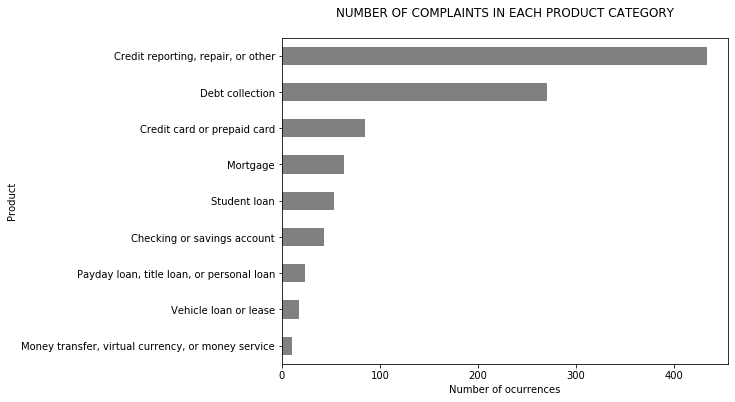

In [11]:
fig = plt.figure(figsize=(8,6))
colors = ['grey','grey','grey','grey','grey','grey','grey','grey','grey',
    'grey','darkblue','darkblue','darkblue']
df2.groupby('Product').Consumer_complaint.count().sort_values().plot.barh(
    ylim=0, color=colors, title= 'NUMBER OF COMPLAINTS IN EACH PRODUCT CATEGORY\n')
plt.xlabel('Number of ocurrences', fontsize = 10);

In [40]:


tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')

# We transform each complaint into a vector
features = tfidf.fit_transform(df2.Consumer_complaint).toarray()

labels = df2.category_id

print("Each of the %d complaints is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))

features.shape

Each of the 1000 complaints is represented by 3120 features (TF-IDF score of unigrams and bigrams)


(1000, 3120)

In [13]:


# Finding the three most correlated terms with each of the product categories
N = 3
for Product, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("\n==> %s:" %(Product))
  print("  * Most Correlated Unigrams are: %s" %(', '.join(unigrams[-N:])))
  print("  * Most Correlated Bigrams are: %s" %(', '.join(bigrams[-N:])))




==> Checking or savings account:
  * Most Correlated Unigrams are: bank, branch, overdraft
  * Most Correlated Bigrams are: savings account, checking account, overdraft fees

==> Credit card or prepaid card:
  * Most Correlated Unigrams are: citi, american, card
  * Most Correlated Bigrams are: synchrony bank, credit card, american express

==> Credit reporting, repair, or other:
  * Most Correlated Unigrams are: inquiries, report, experian
  * Most Correlated Bigrams are: appear report, mistakes appear, report understanding

==> Debt collection:
  * Most Correlated Unigrams are: collect, collection, debt
  * Most Correlated Bigrams are: debt collection, collect debt, debt collector

==> Money transfer, virtual currency, or money service:
  * Most Correlated Unigrams are: 470, paypal, legit
  * Most Correlated Bigrams are: email address, 470 00, transferred xxxx

==> Mortgage:
  * Most Correlated Unigrams are: modification, escrow, mortgage
  * Most Correlated Bigrams are: mortgage pa

In [14]:
X = df2['Consumer_complaint'] # Collection of documents
y = df2['Product'] # Target or the labels we want to predict (i.e., the 13 different complaints of products)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 0)

In [44]:
X

49703    i applied for a loan online on ace cash expres...
49975    I have going to this company since XX/XX/XXXX ...
41978    About six months ago I started getting robo-ca...
47576    XXXX has been non-compliant with removing the ...
45414    My identity was compromised and so I froze my ...
                               ...                        
41455    In XX/XX/XXXX a tree from neighbor yard fell c...
39003    Repeatedly tried to contact Southwest Credit S...
48234    why was I not notified about this company and ...
48696    Today XX/XX/2019 my sister contacted me saying...
49258    I need to file a dispute on Experian Credit re...
Name: Consumer_complaint, Length: 1000, dtype: object

In [33]:
models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

# 5 Cross-validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
    
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])


/home/diskane/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/diskane/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/diskane/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/diskane/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/diskane/anaconda3/lib/python3.7/site-packages/sklearn/linear_mod

In [34]:
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1, 
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc

,Mean Accuracy,Standard deviation
model_name,,
LinearSVC,0.782760,0.028443
LogisticRegression,0.666923,0.012163
MultinomialNB,0.612903,0.022454
RandomForestClassifier,0.516968,0.013006


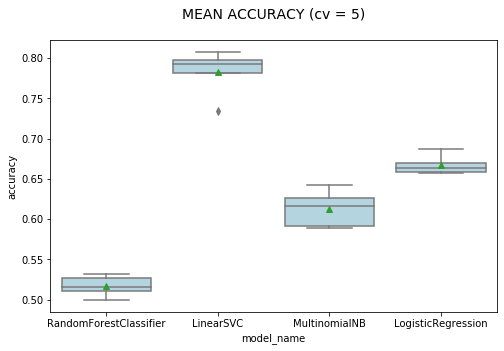

In [35]:
plt.figure(figsize=(8,5))
sns.boxplot(x='model_name', y='accuracy', 
            data=cv_df, 
            color='lightblue', 
            showmeans=True)
plt.title("MEAN ACCURACY (cv = 5)\n", size=14);

In [28]:
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(features, 
                                                               labels, 
                                                               df2.index, test_size=0.25, 
                                                               random_state=1)
model = LinearSVC()
print(type(X_train[0]))
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


<class 'numpy.ndarray'>


numpy.int64

In [37]:


# Classification report
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(y_test, y_pred, 
                                    target_names= df2['Product'].unique()))



				CLASSIFICATIION METRICS

                                                    precision    recall  f1-score   support

         Payday loan, title loan, or personal loan       0.00      0.00      0.00         5
                Credit reporting, repair, or other       0.78      0.89      0.83       111
                                   Debt collection       0.85      0.73      0.78        77
                                          Mortgage       0.85      0.92      0.88        12
                       Credit card or prepaid card       0.74      0.81      0.77        21
                       Checking or savings account       0.43      0.43      0.43         7
                                      Student loan       0.71      0.77      0.74        13
Money transfer, virtual currency, or money service       0.00      0.00      0.00         1
                             Vehicle loan or lease       0.00      0.00      0.00         3

                                          accurac

/home/diskane/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


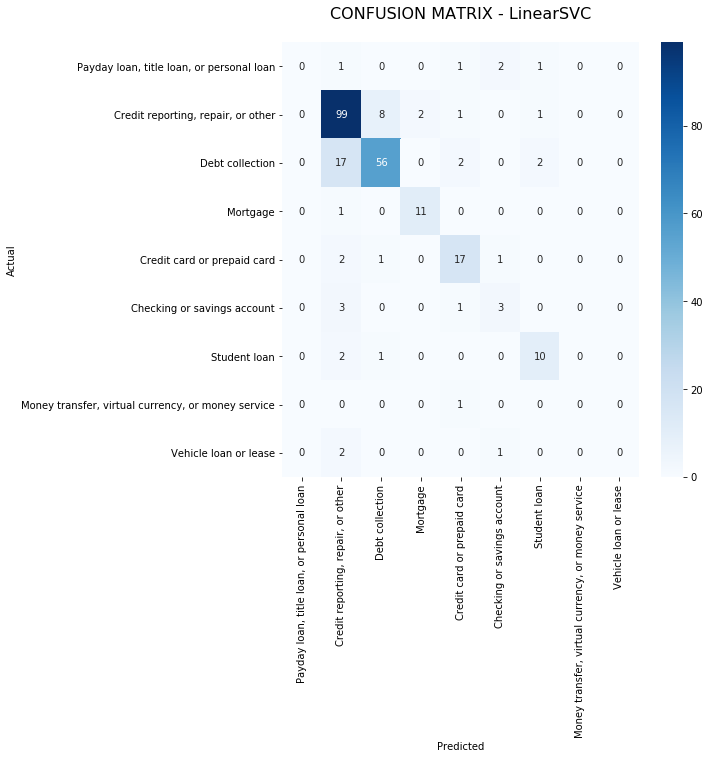

In [38]:


conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=category_id_df.Product.values, 
            yticklabels=category_id_df.Product.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LinearSVC\n", size=16);



In [21]:


X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.25,
                                                    random_state = 0)

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2), 
                        stop_words='english')




In [22]:
type(X_train.iloc[0])

str

In [23]:

fitted_vectorizer = tfidf.fit(X_train)
tfidf_vectorizer_vectors = fitted_vectorizer.transform(X_train)

model = LinearSVC().fit(tfidf_vectorizer_vectors, y_train)

In [40]:


new_complaint = """I have been enrolled back at XXXX XXXX University in the XX/XX/XXXX. Recently, i have been harassed by \
Navient for the last month. I have faxed in paperwork providing them with everything they needed. And yet I am still getting \
phone calls for payments. Furthermore, Navient is now reporting to the credit bureaus that I am late. At this point, \
Navient needs to get their act together to avoid me taking further action. I have been enrolled the entire time and my \
deferment should be valid with my planned graduation date being the XX/XX/XXXX."""
print(model.predict(fitted_vectorizer.transform([new_complaint])))



['Student loan']
